In [1]:
import pickle
import tensorflow as tf
from keras.utils import to_categorical
import keras.layers as layers
from keras import Model
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Mean
import matplotlib.pyplot as plt

c:\Users\terry\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset

In [2]:
DATA_PATH = "gan-data-pickle"

epochs = 10
batch_size = 64
latent_dim = 128

class_strs = [chr(i) for i in range(ord('0'), ord('9')+1)] + [chr(i) for i in range(ord('a'), ord('z')+1)]
num_classes = len(class_strs)

print(num_classes)
print(class_strs)

36
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
with open(DATA_PATH, "rb") as f:
    images, labels = pickle.load(f)

images = images.astype("float32") / 255
labels = to_categorical(labels, num_classes)

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"{images.shape}, {labels.shape}")

(36000, 28, 28, 1), (36000, 36)


# Defining GAN

## Discriminator

In [4]:
def get_discriminator_model(input_channels):
    return Sequential([
        layers.InputLayer((28, 28, input_channels)),

        layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.5),
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.5),

        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ])

## Generator

In [5]:
def get_generator_model(input_channels):
    return Sequential([
        layers.InputLayer((input_channels,)),

        layers.Dense(7 * 7 * input_channels),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, input_channels)),

        layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(filters=1, kernel_size=(7,7),  padding="same", activation="sigmoid"),
    ])

## GAN

In [6]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.disc_loss_tracker = Mean(name="disc_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optim, g_optim, loss):
        super().compile()
        self.d_optim = d_optim
        self.g_optim = g_optim
        self.loss = loss

    def train_step(self, data):
        real_images, labels = data
        labels_channel = labels[:, :, None, None]
        labels_channel = tf.repeat(labels_channel, 784) # 28*28
        labels_channel = tf.reshape(labels_channel, (-1, 28, 28, num_classes))

        batch_size = tf.shape(real_images)[0]
        latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generator_data = tf.concat([latent_vectors, labels], axis=1)
        fake_images = self.generator(generator_data)

        fake_data = tf.concat([fake_images, labels_channel], axis=-1)
        real_data = tf.concat([real_images, labels_channel], axis=-1)

        discriminator_data = tf.concat([fake_data, real_data], axis=0)
        discriminator_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        with tf.GradientTape() as g:
            pred = self.discriminator(discriminator_data)
            d_loss = self.loss(discriminator_labels, pred)
        grads = g.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generator_data = tf.concat([latent_vectors, labels], axis=1)
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as g:
            fake_images = self.generator(generator_data)
            fake_data = tf.concat([fake_images, labels_channel], axis=-1)
            pred = self.discriminator(fake_data)
            g_loss = self.loss(misleading_labels, pred)
        grads = g.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Training

In [7]:
gan = GAN(discriminator=get_discriminator_model(1 + num_classes),
          generator=get_generator_model(latent_dim + num_classes),
          latent_dim=latent_dim)

gan.compile(d_optim=Adam(learning_rate=0.0003),
            g_optim=Adam(learning_rate=0.0003),
            loss=BinaryCrossentropy(from_logits=True))

In [8]:
history = gan.fit(dataset, epochs=epochs)

Epoch 1/10
563/563 [==============================] - 10s 15ms/step - g_loss: 0.8735 - d_loss: 0.6465
Epoch 2/10
563/563 [==============================] - 8s 15ms/step - g_loss: 0.7765 - d_loss: 0.6731
Epoch 3/10
563/563 [==============================] - 8s 15ms/step - g_loss: 1.0700 - d_loss: 0.5266
Epoch 4/10
563/563 [==============================] - 8s 15ms/step - g_loss: 1.8213 - d_loss: 0.2614
Epoch 5/10
563/563 [==============================] - 8s 15ms/step - g_loss: 2.7610 - d_loss: 0.1259
Epoch 6/10
563/563 [==============================] - 8s 15ms/step - g_loss: 3.1520 - d_loss: 0.0809
Epoch 7/10
563/563 [==============================] - 8s 15ms/step - g_loss: 3.5410 - d_loss: 0.0524
Epoch 8/10
563/563 [==============================] - 8s 15ms/step - g_loss: 3.9414 - d_loss: 0.0393
Epoch 9/10
563/563 [==============================] - 8s 15ms/step - g_loss: 4.2492 - d_loss: 0.0292
Epoch 10/10
563/563 [==============================] - 8s 15ms/step - g_loss: 4.5228 - d_l

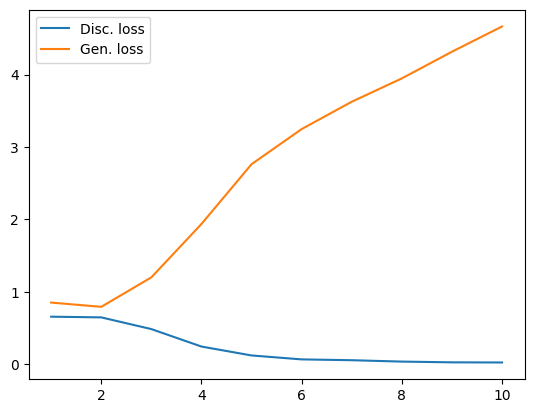

In [9]:
d_loss = history.history["d_loss"]
g_loss = history.history["g_loss"]
epochs = range(1, len(d_loss) + 1)

plt.plot(epochs, d_loss, label="Disc. loss")
plt.plot(epochs, g_loss, label="Gen. loss")
plt.legend()
plt.show()

In [10]:
generator = gan.generator
discriminator = gan.discriminator
# generator.save(f"generator_{epochs}.keras")
# discriminator.save(f"discriminator_{epochs}.keras")

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 12ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 12ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 12ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 12ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 11ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 12ms/step
[[1.

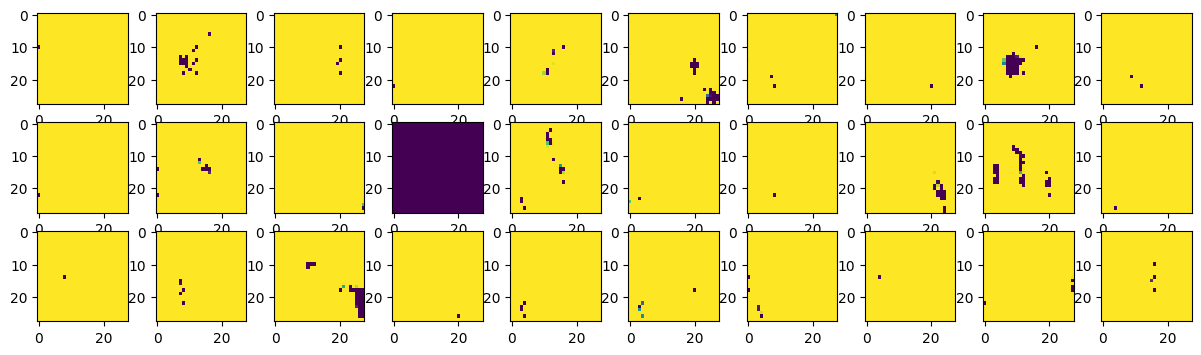

In [19]:
_, ax = plt.subplots(3, 10, figsize=(15, 4))
for label in range(3):
    for i in range(10):
        latent_vectors = tf.random.normal(shape=(1, latent_dim))
        test_label = to_categorical([label], num_classes=num_classes)
        print(test_label)
        generator_data = tf.concat([latent_vectors, test_label], axis=1)
        fake = generator.predict(generator_data)
        ax[label, i].imshow(fake[0])
plt.show()

In [12]:
# test = load_model(f"generator_{epochs}.keras")

# latent_vectors = tf.random.normal(shape=(1, latent_dim))
# test_label = labels[0:1]
# generator_data = tf.concat([latent_vectors, test_label], axis=1)

# test.compile()
# fake = test.predict(generator_data)
# plt.imshow(fake[0])
# plt.show()